# Loan Prediction Problem

You are working as a Data Scientist in a fintech company.

The company wants to predict whether a customer will default on a loan.
You are given a dataset with:
- Customer demographic data
- Financial behavior features
- Transaction history

Single models are giving moderate performance, but management wants better accuracy and stability.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

## Load Dataset

In [2]:
path = '../../Data_Source/Kaggle/Loan_Prediction_Problem_Datasets/train_u6lujuX_CVtuZ9i.csv'
df = pd.read_csv(path)

# Inspect Dataset

In [3]:
df.shape

(614, 13)

In [4]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Data Preprocessing

### Handling Missing Values

In [11]:
# handling the missing values
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['Loan_Status'].fillna('N', inplace=True)

In [12]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

## Handling Outliers

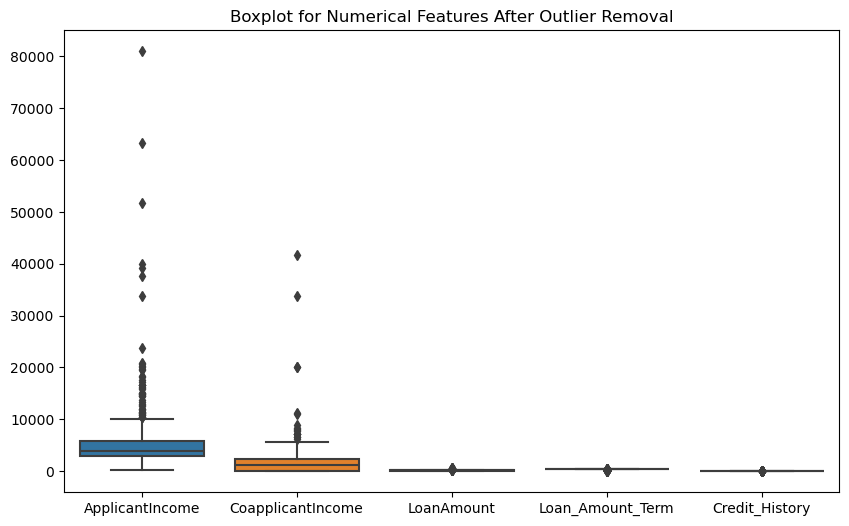

In [9]:
# again check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
plt.title('Boxplot for Numerical Features After Outlier Removal')
plt.show()

In [13]:
outlier_percentages = {}
original_shape = df.shape[0]

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        percentage = (outliers_count / original_shape) * 100
        outlier_percentages[col] = round(percentage, 2)

print("Outlier Percentages:")
for col, pct in outlier_percentages.items():
    print(f"{col}: {pct}%")

Outlier Percentages:
ApplicantIncome: 8.14%
CoapplicantIncome: 2.93%
LoanAmount: 6.68%
Loan_Amount_Term: 14.33%
Credit_History: 14.5%


In [16]:
# deleting outliers
delete_outlier_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for col in delete_outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [17]:
outlier_percentages = {}
original_shape = df.shape[0]

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        percentage = (outliers_count / original_shape) * 100
        outlier_percentages[col] = round(percentage, 2)

print("Outlier Percentages:")
for col, pct in outlier_percentages.items():
    print(f"{col}: {pct}%")

Outlier Percentages:
ApplicantIncome: 4.62%
CoapplicantIncome: 0.96%
LoanAmount: 0.58%
Loan_Amount_Term: 14.42%
Credit_History: 14.81%


### Encode Features

In [18]:
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [20]:
df.dtypes

Loan_ID                int32
Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int32
dtype: object

### Feature Selection

In [21]:
X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df.Loan_Status

### Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build Base Model

In [43]:
base_models = [
    ('lr', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('svm', SVC(kernel='rbf', C=1, gamma='scale'))
]

In [44]:
meta_model = LogisticRegression()

## Build Stacking Classifier

In [45]:
classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

classifier.fit(X_train_scaled, y_train)

,estimators,"[('lr', ...), ('knn', ...), ...]"
,final_estimator,LogisticRegression()
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Evaluation

In [46]:
y_pred = classifier.predict(X_test_scaled)

In [47]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8076923076923077